In [1]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, OrdinalEncoder

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import auc as auc_temp

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_theme(style='darkgrid')

import time

# Export dataFrame's as images
import dataframe_image as dfi

# import my utility methods for this project
import utils_practical_2 as my_utils

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger().setLevel(logging.INFO)

# On to Modeling ...

**This notebook picks up from the Data Investigation (see ```DataInvestigation.ipynb```)**

[Local file](DataInvestigation.ipynb)
[Github](https://github.com/fazeelgm/UCB_ML_AI_PracticalApp_II/blob/main/DataInvestigation.ipynb)

## Data Cleanup

The data cleansing results are as follows:

In [6]:
# vehicles_raw, vehicles_cleansed = my_utils.get_cleansed_data()

In [7]:
# vehicles_cleansed.info()

# On to Modeling ...

While investigating the different features of our dataset during the data investigation, I learned two things:

1. The data is very noisy with extreme outliers - I removed null data and outliers as much as possible
   * 66,180 samples were dropped, preserving 84.50% of the original data
3. To aid in this effort, I researched the used car marketplace to get some idea of pricing, important features that drive price and potential inventory segments

## Initial Hypothesis

Based on Price inspection, a potential hypothesis arose that the used car inventory is _segmented_ based on the following price bands:

![](images/candidate-price-segments.png)

In addition, market research suggested that typical used cars can be categoriezed into price ranges like Budget, Mid, Luxury, etc. that will be based on feature groups. I looked at ```<price, year, condition, odometer>``` combinations and saw that there was clustering behavior as shown by the scatter plots below:

![](images/scatter-price-odo-condition-budget.png)
![](images/scatter-price-odo-year-entry.png)

So, I will now use clustering techniques to see if we can observe natural clustering of features in our sample population.

# Final Modeling

## Data Cleaning

In [12]:
vehicles_raw, vehicles_cleansed = my_utils.get_cleansed_data()

Reading data/vehicles.csv ... Done: (426880, 18)

Cleansing price column ... 
... Removing price outliers using ModZ method ... 
... ModZ: 9450.0, med: 13950.0, const: 0.6745
... Time: 0.1518878936767578
... Removed 5,790 outliers
... Removing cars with price = 0 ...  Removed 32,895 rows
Done: (421090, 19) -> (388195, 19)

DropNA from columns: 
... year: 1,029 rows (0.27% of total): 388,195 -> 387,166
... manufacturer: 16,609 rows (4.28% of total): 388,195 -> 371,586
... fuel: 19,173 rows (4.94% of total): 388,195 -> 369,022
... title_status: 26,730 rows (6.89% of total): 388,195 -> 361,465
... odometer: 28,960 rows (7.46% of total): 388,195 -> 359,235
... transmission: 30,742 rows (7.92% of total): 388,195 -> 357,453
Done: (388195, 19) -> (360700, 19)

Dropping columns: ['mod_zscore', 'id', 'model']
... mod_zscore
... id
... model
Done: (360700, 19) -> (360700, 16)

Data Transformations:
... year float -> int: Done
... odometer float -> int: Done

Category Transformations:
... Convert

In [13]:
vehicles_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360700 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   region        360700 non-null  object  
 1   price         360700 non-null  int64   
 2   year          360700 non-null  int64   
 3   manufacturer  360700 non-null  category
 4   condition     223668 non-null  category
 5   cylinders     213522 non-null  category
 6   fuel          360700 non-null  category
 7   odometer      360700 non-null  int64   
 8   title_status  360700 non-null  category
 9   transmission  360700 non-null  category
 10  VIN           219818 non-null  object  
 11  drive         252582 non-null  category
 12  size          104338 non-null  category
 13  type          282300 non-null  category
 14  paint_color   257706 non-null  category
 15  state         360700 non-null  category
dtypes: category(11), int64(3), object(2)
memory usage: 20.3+ MB


In [14]:
vehicles_cleansed.columns

Index(['region', 'price', 'year', 'manufacturer', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive',
       'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [15]:
# removed cols: 'region', 'manufacturer', 'VIN', 'paint_color', 'state'
drop_cols = ['region', 'manufacturer', 'VIN', 'paint_color', 'state']
features=['year', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 
          'transmission', 'drive', 'size', 'type']

In [16]:
# Create a copy of the clean data and remove unwanted columnss
data = vehicles_cleansed.copy()
data.drop(columns=drop_cols, inplace=True)

In [17]:
# remove nulls before splitting data
print('Dropping nulls: {} -> '.format(data.shape), end='')
data.dropna(subset=['condition', 'cylinders', 'drive', 'size', 'type'], axis='index', inplace=True)
print(' {}'.format(data.shape))

Dropping nulls: (360700, 11) ->  (78626, 11)


In [18]:
data.columns

Index(['price', 'year', 'condition', 'cylinders', 'fuel', 'odometer',
       'title_status', 'transmission', 'drive', 'size', 'type'],
      dtype='object')

## Create Train/Test splits

In [20]:
X = data[features]
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78626 entries, 31 to 426833
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          78626 non-null  int64   
 1   condition     78626 non-null  category
 2   cylinders     78626 non-null  category
 3   fuel          78626 non-null  category
 4   odometer      78626 non-null  int64   
 5   title_status  78626 non-null  category
 6   transmission  78626 non-null  category
 7   drive         78626 non-null  category
 8   size          78626 non-null  category
 9   type          78626 non-null  category
dtypes: category(8), int64(2)
memory usage: 2.4 MB


## Data Preparation for Modeling

In [23]:
selector = make_column_selector(dtype_include=['object', 'category'])
data.select_dtypes(include=['object', 'category']).columns

Index(['condition', 'cylinders', 'fuel', 'title_status', 'transmission',
       'drive', 'size', 'type'],
      dtype='object')

In [24]:
# Preprocess the data
# One-hot encode the 'condition' categorical features
# Scale numeric features
transformer = make_column_transformer(
    (OneHotEncoder(drop = 'first'), selector),
    remainder= StandardScaler()
)
transformer

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12f7f1010>)])

## Baseline Regression Models

In [26]:
models = [
    LinearRegression(),
    Ridge(alpha=1.0),
    Lasso(alpha=0.1)
]

# save results for tabulation
results_baseline = []

In [27]:
# Evaluate models
def get_model_metrics_as_results(model_name, y_preds, y_test, score):
    """
    Build standardized results row given the predictions and y_test values

    :param model_name: Model name for labeling the row in the table
    :param y_preds: Predictions of y_test
    :param y_test: Test y
    :param score: Model Score is passed in
    :return: Returns single row of results summary table containing:
    
        [model_name, MAE, MSE, RMSE, R2_Score]
    """

    start_time = time.time()

    logging.debug(f'Working on {model_name}')

    # get metrics
    mae = mean_absolute_error(y_preds, y_test)
    mse = mean_squared_error(y_preds, y_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_preds, y_test)

    lapse = time.time() - start_time
    
    logging.debug(f'... {model_name}: MAE: {mae:,.4f}, MSE: {mse:,.4f}, RMSE: {rmse:,.4f}, R2: {r2:,.4f}, Score: {score:,.4f}, time: {lapse:,.4f}')

    return [model_name, mae, mse, rmse, score]

In [28]:
# logging.getLogger().setLevel(logging.DEBUG)

# results_baseline = []

# iterate over the models and build results DF
for model in models:
    clf = Pipeline([
        ('transformer', transformer),
        ('model', model)
    ])
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)

    model_name = clf.get_params()['model'].__class__.__name__
    score = clf.score(X_test, y_test)

    results_baseline.append(get_model_metrics_as_results(model_name, y_preds, y_test, score))

logging.getLogger().setLevel(logging.INFO)

In [29]:
# Generate results table
results_baseline_df = pd.DataFrame(results_baseline, 
                                   columns=['Model','MAE', 'MSE', 'RMSE', 'R2 Score']
                                  ).set_index('Model')


# Export results for README
results_baseline_df_styled = my_utils.df_style_floats(results_baseline_df)
dfi.export(results_baseline_df_styled, 'images/results_baseline_table.png')

print('RESULTS: Baseline metrics without any optimization\n')
results_baseline_df_styled

RESULTS: Baseline metrics without any optimization



,MAE,MSE,RMSE,R2 Score
Model,,,,
LinearRegression,"5,946.1381","68,680,449.6276","8,287.3669",0.4277
Ridge,"5,946.0982","68,679,488.7110","8,287.3089",0.4277
Lasso,"5,946.1342","68,680,502.5796","8,287.3701",0.4277


All the models performed very closely without any clear winners. Given the target variable measurement unit, price in dollars per car:

* All the models showed roughly $8,287 (RMSE) average difference between the predicted and actual prices from the test dataset that was not used for the training of the model
* The R2 Score shows thay they each captured 42.77% of the variance in the price

We will now optimize the models to see if we can improve the results and pick a clear winner.

## Model Tuning: Hyperparameter Tuning and Cross Validation

In [32]:
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso()
}

param_grid = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0, 100.0]},
    'Lasso': {'alpha': [0.01, 0.1, 1.0, 10.0]}    
}

In [33]:
# save results for tabulation
results_tuned = []
best_models = {}
best_params = {}
cv_scores = {}
cv_mses = {}

# Scale the data
X_train_scaled = transformer.fit_transform(X_train)
X_test_scaled = transformer.fit_transform(X_test)

# Run cross validation using GridSearchCV
cv=5
for model in models:
    clf = models[model]
    logging.debug(f'clf: {type(clf)}, params: {param_grid[model]}')
    grid = GridSearchCV(clf, param_grid=param_grid[model], cv=cv, scoring='neg_mean_squared_error')
    grid.fit(X_train_scaled, y_train)

    
    # Save the tuning metrics for this model class
    best_models[model] = grid.best_estimator_
    cv_score = cross_val_score(clf, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
    cv_scores[model] = cv_score
    cv_mses[model] = -np.mean(cv_score)
    best_params[model] = grid.best_params_
    
    logging.debug(f'Best alpha: {grid.best_params_}')
    logging.debug(f'CV Score: {cv_score}')
    logging.debug(f'CV MSE: {-np.mean(cv_score)}')
    logging.debug(f'CV Best Score: {-grid.best_score_}')
    logging.debug(f'CV Best RMSE: {np.sqrt(-grid.best_score_)}')

    y_preds = grid.best_estimator_.predict(X_test_scaled)
    score = grid.score(X_test_scaled, y_test)
    r2 = r2_score(y_test, y_preds)
    logging.debug(f'Score: {score}, r2: {r2}')

    results_tuned.append(get_model_metrics_as_results(model, y_preds, y_test, r2))

We add LinearRegression to the results manually as there is no need for cross-validation

In [35]:
# Handle LinearRegression manually
linear_model = LinearRegression()

# Train Linear Regression model
linear_model.fit(X_train_scaled, y_train)

linear_cv_score = cross_val_score(linear_model, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
logging.debug(f'Linear Regression CV MSE: {-np.mean(linear_cv_score)}')

# This is the best estimator for LinearRegression as there is no tuning
model='LinearRegression'
best_models[model] = linear_model
cv_scores[model] = linear_cv_score
cv_mses[model] = -np.mean(linear_cv_score)
best_params[model] = ''

# Make predictions
linear_pred = linear_model.predict(X_test_scaled)

results_tuned.append(get_model_metrics_as_results(model, linear_pred, y_test, r2_score(y_test, linear_pred)))

In [36]:
# Generate results table
results_tuned_df = pd.DataFrame(results_tuned,
                                columns=['Model - Tuned','MAE', 'MSE', 'RMSE', 'R2 Score']
                               ).set_index('Model - Tuned')

# Add BestParams as a new column
results_tuned_df['CV MSE'] = results_tuned_df.index.map(cv_mses)
results_tuned_df['CV Best Params'] = results_tuned_df.index.map(best_params)

# Export results for README
results_tuned_df_styled = my_utils.df_style_floats(results_tuned_df)
dfi.export(results_tuned_df_styled, 'images/results_tuned_table.png')

## Model Assessment

### Best Model: Ridge Regression

In [39]:
print('RESULTS: Baseline Model metrics without any optimization\n')
results_baseline_df_styled

RESULTS: Baseline Model metrics without any optimization



,MAE,MSE,RMSE,R2 Score
Model,,,,
LinearRegression,"5,946.1381","68,680,449.6276","8,287.3669",0.4277
Ridge,"5,946.0982","68,679,488.7110","8,287.3089",0.4277
Lasso,"5,946.1342","68,680,502.5796","8,287.3701",0.4277


In [40]:
print('RESULTS: Optimized Model results after hyperparameter tuning and cross-validation\n')
results_tuned_df_styled

RESULTS: Optimized Model results after hyperparameter tuning and cross-validation



,MAE,MSE,RMSE,R2 Score,CV MSE,CV Best Params
Model - Tuned,,,,,,
Ridge,"5,962.2476","68,590,535.2792","8,281.9403",0.4285,"70,600,488.0763",{'alpha': 10.0}
Lasso,"5,962.8228","68,595,984.7091","8,282.2693",0.4284,"70,589,729.0634",{'alpha': 1.0}
LinearRegression,"5,962.5318","68,593,107.6260","8,282.0956",0.4285,"70,602,026.8617",


Again, all the models performed very closely without any clear winners. 

However, the optimized Ridge Model with alpha=10.0 showed the least average difference between predicted and actual prices (\\$8,281.94 vs \\$8,287 RMSE) and a captured more variance across the features (42.85%  vs 42.77% R2 Score) for the **best performing Ridge model**. 

In addition, the base price of a car is given by the y-intercept for the model: $22,490.54, with each feature adding or subtracting from this value based on the training features.

### Visualizing Actual vs Predicted Prices

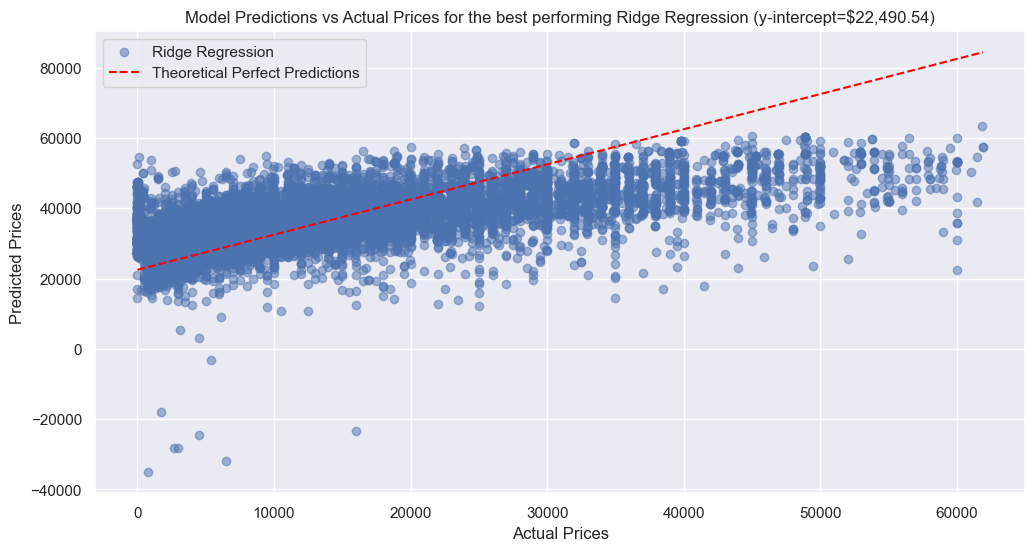

In [43]:
# Plot predictions
best_model = best_models['Ridge']
y_preds = best_model.predict(X_test_scaled)
y_intercept = best_model.intercept_

# Adjust for the y-intercept
y_preds = np.add(y_preds, y_intercept)
perfect_pt_1 = [min(y_test), max(y_test)]
perfect_pt_2 = [min(y_test), max(y_test)] + y_intercept

plt.figure(figsize=(12, 6))
plt.scatter(x=y_test, y=y_preds, label='Ridge Regression', alpha=0.5)
plt.plot(perfect_pt_1, perfect_pt_2, color='red', linestyle='--', label='Theoretical Perfect Predictions')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Model Predictions vs Actual Prices for the best performing Ridge Regression (y-intercept=${y_intercept:,.2f})')
plt.legend()
plt.savefig('images/scatter-optimized-preds-v-test.png')
plt.show()

In [44]:
# # # How to get the list of available Displays for my version of sklearn
# # from sklearn.utils.discovery import all_displays

# # displays = all_displays()
# # displays

# ### ValidationCurveDisplay

# from sklearn.model_selection import ValidationCurveDisplay

# param_name, param_range = 'alpha', [0.1, 1.0, 10.0, 100.0]
# clf = Ridge()

# ValidationCurveDisplay.from_estimator(clf, X_test_scaled, y_test,
#                                       param_name=param_name,
#                                       param_range=param_range,
#                                       scoring='neg_mean_squared_error',
#                                       cv=5, n_jobs=-1)
# plt.show()

### PredictionErrorDisplay: Residuals Comparison

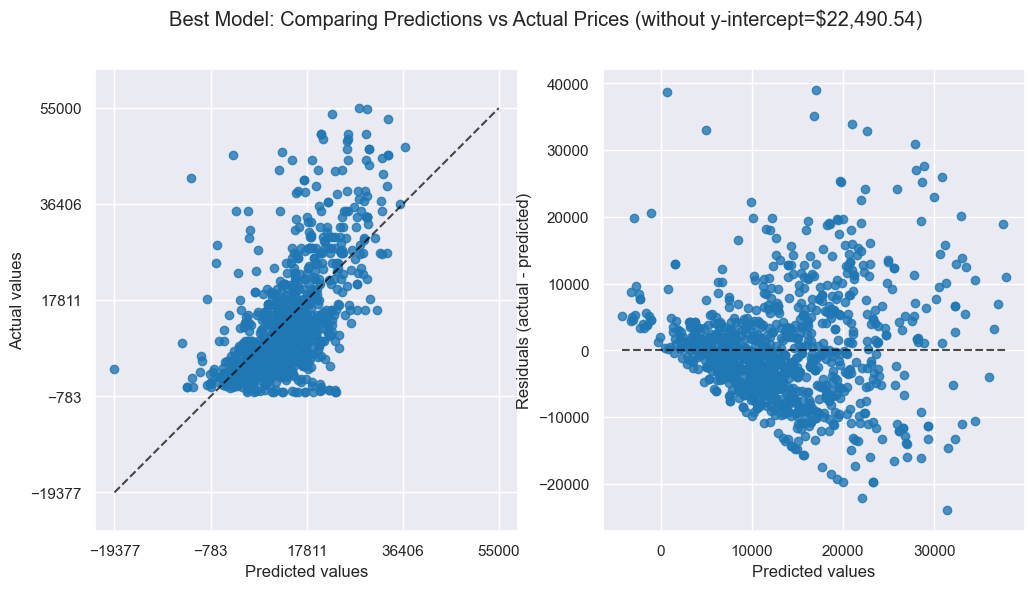

In [46]:
from sklearn.metrics import PredictionErrorDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
PredictionErrorDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=axes[0], kind="actual_vs_predicted")
PredictionErrorDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=axes[1], kind="residual_vs_predicted")

plt.suptitle(f'Best Model: Comparing Predictions vs Actual Prices (without y-intercept=${y_intercept:,.2f})')
plt.savefig('images/optimized-PredictionErrorDisplay.png')
plt.show()

### Interpreting the Model Results

In [48]:
# get the transformed feature names
cat_features = transformer.named_transformers_.onehotencoder.get_feature_names_out()
num_features = transformer.named_transformers_.remainder.get_feature_names_out()
feature_names = np.concatenate((cat_features, num_features))
# feature_names

In [49]:
# build the feature importance DF
feature_imp = []
for feature, coef in zip(feature_names, best_model.coef_):
    if coef != 0:
        # print(f'{feature}: {coef}')
        feature_imp.append([feature, coef])

feature_imp_df = pd.DataFrame(data=feature_imp, columns=['Feature', 'Coefficient'])#.set_index('Feature')
feature_imp_df['Importance'] = np.abs(feature_imp_df.Coefficient)

# Sort the DF
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Add cumulative importance
feature_imp_df['Cumulative Importance'] = feature_imp_df['Importance'].cumsum() / feature_imp_df['Importance'].sum()
feature_imp_df['Percent Contribution'] = feature_imp_df['Cumulative Importance'] * 100

print(f'Impact of each feature to the Base Price: ${y_intercept:,.2f} (y-intercept)')
feature_imp_df[['Feature', 'Coefficient', 'Percent Contribution']].set_index('Feature').rename(columns={'Coefficient':'Price Impact'})

Impact of each feature to the Base Price: $22,490.54 (y-intercept)


,Price Impact,Percent Contribution
Feature,,
fuel_gas,-8908.744248,7.029035
fuel_other,-8896.323056,14.048269
condition_fair,-7788.784075,20.193651
fuel_hybrid,-7736.689863,26.297930
transmission_other,-7525.440396,32.235532
condition_salvage,-6101.878910,37.049939
type_truck,5998.519308,41.782795
condition_new,5873.857990,46.417292
type_convertible,5285.161515,50.587305


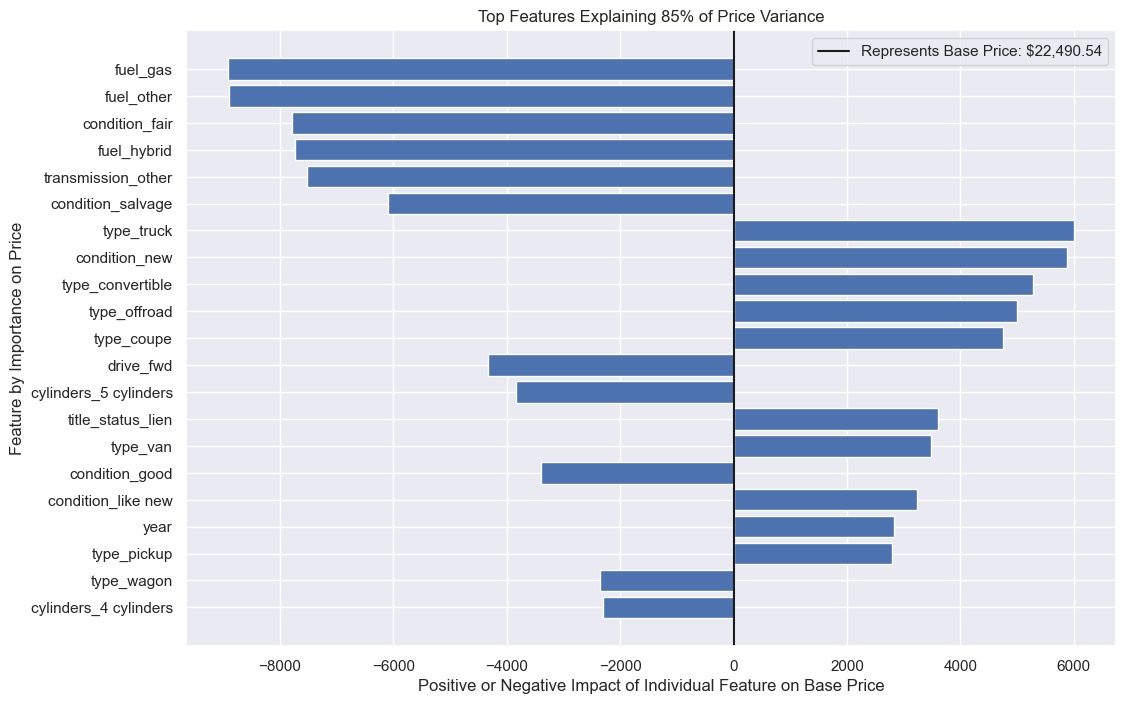

In [50]:
# Top features that explain X% of the variance
top_n = .85
top_features = feature_imp_df[feature_imp_df['Cumulative Importance'] <= top_n]

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.axvline(x=0, color="k", linestyle="-", label=f'Represents Base Price: ${y_intercept:,.2f}')

plt.xlabel(f'Positive or Negative Impact of Individual Feature on Base Price')
plt.ylabel('Feature by Importance on Price')

plt.title(f'Top Features Explaining {top_n * 100:,.0f}% of Price Variance')
plt.gca().invert_yaxis()
plt.savefig('images/feature_importance.png')
plt.legend()
plt.show()

## Segmentation Analysis

In [52]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,78626.0,13173.496312,11070.449385,1.0,5400.0,9500.0,17818.75,62900.0
year,78626.0,2008.031987,10.305272,1900.0,2005.0,2010.0,2014.00,2022.0
odometer,78626.0,124893.310864,206705.825294,0.0,75289.0,116000.0,157196.50,10000000.0


In [53]:
veh_budget = data.query('price <= 10000 and year <= 2016 and odometer >= 100000')
veh_entry = data.query('(price>=10000 and price<=15000) and (year>=2016 and year<=2019) and (odometer>=60000 and odometer<=100000)')
veh_mid = data.query('(price>=15000 and price<=25000) and (year>=2019 and year<=2021) and (odometer>=40000 and odometer<=60000)')
veh_upper = data.query('(price>=25000 and price<=35000) and (year>=2021 and year<=2023) and (odometer<=30000)')
veh_premium = data.query('(price>=35000) and (year>=2022) and (odometer<=20000)')

In [54]:
veh_premium.shape

(0, 11)

DEBUG: Segment: Budget, #Samples: 32538
DEBUG: X: (32538, 10) y: (32538,)
DEBUG: X_scaled: (32538, 42)
DEBUG: X_train: (26030, 42) X_test: (6508, 42) y_train: (26030,) y_test: (6508,)
DEBUG: Score: 0.2587590788248243, r2: 0.2587590788248243, y_int: 8070.265093995571
DEBUG: Segment: Entry, #Samples: 726
DEBUG: X: (726, 10) y: (726,)
DEBUG: X_scaled: (726, 34)
DEBUG: X_train: (580, 34) X_test: (146, 34) y_train: (580,) y_test: (146,)
DEBUG: Score: 0.1557494795137332, r2: 0.1557494795137332, y_int: 13898.360872919158
DEBUG: Segment: Mid, #Samples: 79
DEBUG: X: (79, 10) y: (79,)
DEBUG: X_scaled: (79, 25)
DEBUG: X_train: (63, 25) X_test: (16, 25) y_train: (63,) y_test: (16,)
DEBUG: Score: -0.170113990761674, r2: -0.170113990761674, y_int: 19831.688686322203
DEBUG: Segment: Upper, #Samples: 29
DEBUG: X: (29, 10) y: (29,)
DEBUG: X_scaled: (29, 18)
DEBUG: X_train: (23, 18) X_test: (6, 18) y_train: (23,) y_test: (6,)
DEBUG: Score: -0.11333665198882947, r2: -0.11333665198882947, y_int: 30788.831

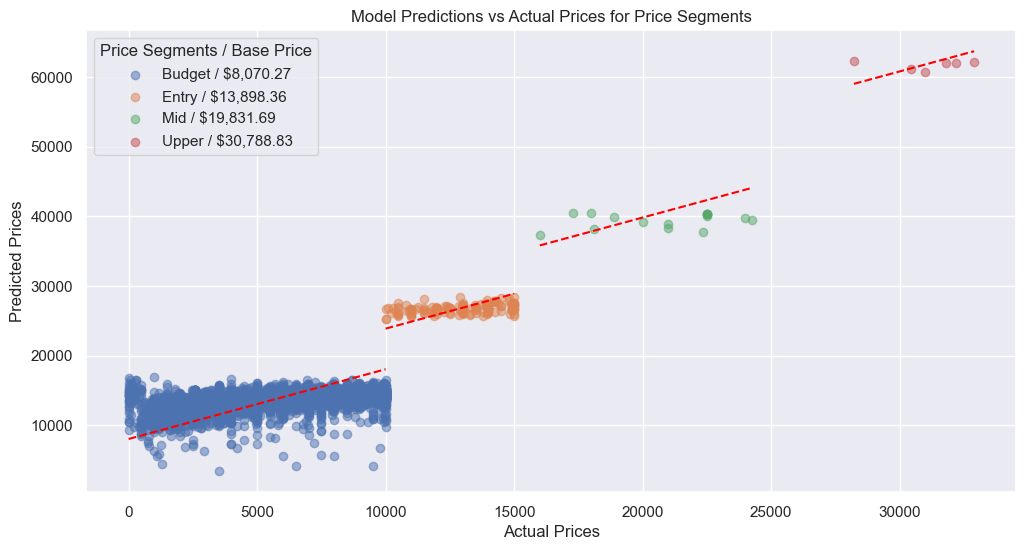

In [55]:
logging.getLogger().setLevel(logging.DEBUG)

segments = {
    'Budget' : veh_budget,
    'Entry' : veh_entry,
    'Mid' : veh_mid,
    'Upper' : veh_upper,
    'Premium' : veh_premium
}

plt.figure(figsize=(12, 6))

# seg_preds = {}
for segment in segments:
    logging.debug(f'Segment: {segment}, #Samples: {len(segments[segment])}')

    if len(segments[segment]) <= 0:
        break
    
    # Predict on the segment
    X = segments[segment][features]
    y = segments[segment]['price']
    logging.debug(f'X: {X.shape} y: {y.shape}')
    
    # Scale the data
    X_scaled = transformer.fit_transform(X)
    logging.debug(f'X_scaled: {X_scaled.shape}')
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    logging.debug(f'X_train: {X_train.shape} X_test: {X_test.shape} y_train: {y_train.shape} y_test: {y_test.shape}')

    ridge = best_model.fit(X_train, y_train)
    
    # Plot predictions
    y_preds = best_model.predict(X_test)
    score = best_model.score(X_test, y_test)
    r2 = r2_score(y_test, y_preds)
    y_intercept = best_model.intercept_
    logging.debug(f'Score: {score}, r2: {r2}, y_int: {y_intercept}')
    y_preds = y_preds + y_intercept
    # seg_preds[segment] = y_preds

    perfect_pt_1 = [min(y_test), max(y_test)]
    # perfect_pt_2 = [min(y_test), max(y_test)]
    perfect_pt_2 = [min(y_test), max(y_test)] + y_intercept
    plt.scatter(x=y_test, y=y_preds, label=f'{segment} / ${y_intercept:,.2f}', alpha=0.5)
    plt.plot(perfect_pt_1, perfect_pt_2, color='red', linestyle='--')#, label='Theoretical Perfect Predictions')

plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Model Predictions vs Actual Prices for Price Segments')
plt.legend().set_title('Price Segments / Base Price')
plt.savefig('images/scatter-segments-preds-v-test.png')
plt.show()

#### Single Segment

In [57]:
# Predict on the segment
X = veh_budget[features]
y = veh_budget['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
X_train_scaled = transformer.fit_transform(X_train)
X_test_scaled = transformer.fit_transform(X_test)

ridge = best_model.fit(X_train_scaled, y_train)

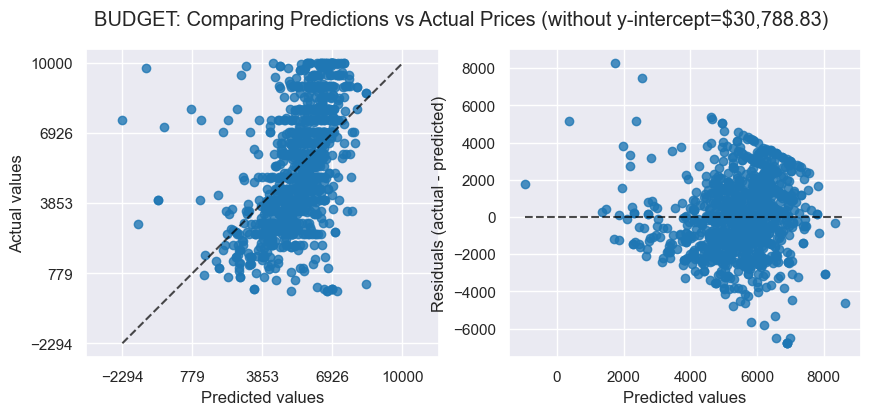

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
PredictionErrorDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=axes[0], kind="actual_vs_predicted")
PredictionErrorDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=axes[1], kind="residual_vs_predicted")

plt.suptitle(f'BUDGET: Comparing Predictions vs Actual Prices (without y-intercept=${y_intercept:,.2f})')
plt.savefig('images/budget_predictions.png')
plt.show()

In [59]:
logging.getLogger().setLevel(logging.DEBUG)
# Plot predictions
# best_model = best_models['Ridge']
y_preds = best_model.predict(X_test_scaled)
score = best_model.score(X_test_scaled, y_test)
r2 = r2_score(y_test, y_preds)
logging.debug(f'Score: {score}, r2: {r2}')
y_intercept = best_model.intercept_

DEBUG: Score: 0.2587006248859123, r2: 0.2587006248859123


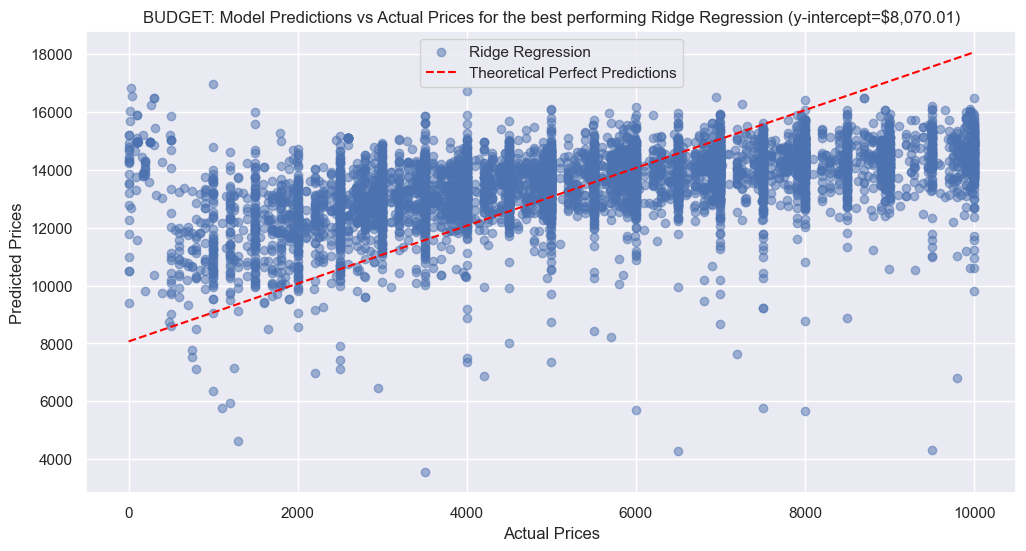

In [60]:
# Adjust for the y-intercept
y_preds = np.add(y_preds, y_intercept)
perfect_pt_1 = [min(y_test), max(y_test)]
perfect_pt_2 = [min(y_test), max(y_test)] + y_intercept

plt.figure(figsize=(12, 6))
plt.scatter(x=y_test, y=y_preds, label='Ridge Regression', alpha=0.5)
plt.plot(perfect_pt_1, perfect_pt_2, color='red', linestyle='--', label='Theoretical Perfect Predictions')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'BUDGET: Model Predictions vs Actual Prices for the best performing Ridge Regression (y-intercept=${y_intercept:,.2f})')
plt.legend()
plt.savefig('images/scatter-optimized-preds-v-test.png')
plt.show()